# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [70]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import datetime
from multiprocessing import Queue, Pool, cpu_count
from threading import Thread
import six
import collections
import struct
from urllib.request import urlretrieve

from matplotlib import colors
from matplotlib import pyplot as plt

# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("tensorflow_object_detection_api/models/research/object_detection/")
sys.path.append("tensorflow_object_detection_api/models/research/")

from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation

In [73]:
# What model to download (fast to slow)
# MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
# MODEL_NAME = 'ssd_inception_v2_coco_11_06_2017'
# MODEL_NAME = 'rfcn_resnet101_coco_11_06_2017'
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'models/' + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [74]:
# Download model if it doesn't exist
if (not os.path.isfile(PATH_TO_CKPT)):
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
      file_name = os.path.basename(file.name)
      if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd()+'/models')

In [75]:
# Load labelmap
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Object detection

The frozen graph is used to run a prediction on the input image. The bounding boxes and according labels are extracted.

In [76]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    
    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    
    rect_points, class_names, class_colors = draw_boxes_and_labels(
        boxes=np.squeeze(boxes),
        classes=np.squeeze(classes).astype(np.int32),
        scores=np.squeeze(scores),
        category_index=category_index,
        min_score_thresh=.5)
    
    return dict(rect_points=rect_points, class_names=class_names, class_colors=class_colors)

Following [this post](http://www.pyimagesearch.com/2015/12/21/increasing-webcam-fps-with-python-and-opencv/) by Adrian Rosebrock, the images from webcam are read using threading to speed up the process

In [77]:
class WebcamVideoStream:
    def __init__(self, src, width, height):
        # initialize the video camera stream and read the first frame from the stream
        self.stream = cv2.VideoCapture(src)
        self.stream.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        self.stream.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        (self.grabbed, self.frame) = self.stream.read()

        # initialize the variable used to indicate if the thread should be stopped
        self.stopped = False

    def start(self):
        # start the thread to read frames from the video stream
        Thread(target=self.update, args=()).start()
        return self

    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                del(self.stream)

                for i in range (1,5):
                    cv2.waitKey(1)
                return

            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
        # return the frame most recently read
        return self.frame

    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True

Following [this post](https://medium.com/towards-data-science/building-a-real-time-object-recognition-app-with-tensorflow-and-opencv-b7a2b4ebdc32) by Dat Tran, I added the use of the multiprocessing library to speed up object detection.
The function to draw the bounding boxes and labels is also and adapted version from Dat Tran who adapted it from the visualisation function in the official tensorflow object detection API repo.

In [78]:
# Marking bounding boxes and annotations on the image
def draw_boxes_and_labels(
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=None,
        keypoints=None,
        max_boxes_to_draw=20,
        min_score_thresh=.5,
        agnostic_mode=False):
    """Returns boxes coordinates, class names and colors
    Args:
      boxes: a numpy array of shape [N, 4]
      classes: a numpy array of shape [N]
      scores: a numpy array of shape [N] or None.  If scores=None, then
        this function assumes that the boxes to be plotted are groundtruth
        boxes and plot all boxes as black with no classes or scores.
      category_index: a dict containing category dictionaries (each holding
        category index `id` and category name `name`) keyed by category indices.
      instance_masks: a numpy array of shape [N, image_height, image_width], can
        be None
      keypoints: a numpy array of shape [N, num_keypoints, 2], can
        be None
      max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
        all boxes.
      min_score_thresh: minimum score threshold for a box to be visualized
      agnostic_mode: boolean (default: False) controlling whether to evaluate in
        class-agnostic mode or not.  This mode will display scores but ignore
        classes.
    """
    # Create a display string (and color) for every box location, group any boxes
    # that correspond to the same location.
    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    box_to_instance_masks_map = {}
    box_to_keypoints_map = collections.defaultdict(list)
    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist())
            if instance_masks is not None:
                box_to_instance_masks_map[box] = instance_masks[i]
            if keypoints is not None:
                box_to_keypoints_map[box].extend(keypoints[i])
            if scores is None:
                box_to_color_map[box] = 'black'
            else:
                if not agnostic_mode:
                    if classes[i] in category_index.keys():
                        class_name = category_index[classes[i]]['name']
                    else:
                        class_name = 'N/A'
                    display_str = '{}: {}%'.format(
                        class_name,
                        int(100 * scores[i]))
                else:
                    display_str = 'score: {}%'.format(int(100 * scores[i]))
                box_to_display_str_map[box].append(display_str)
                if agnostic_mode:
                    box_to_color_map[box] = 'DarkOrange'
                else:
                    box_to_color_map[box] = standard_colors()[
                        classes[i] % len(standard_colors())]

    # Store all the coordinates of the boxes, class names and colors
    color_rgb = color_name_to_rgb()
    rect_points = []
    class_names = []
    class_colors = []
    for box, color in six.iteritems(box_to_color_map):
        ymin, xmin, ymax, xmax = box
        rect_points.append(dict(ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax))
        class_names.append(box_to_display_str_map[box])
        class_colors.append(color_rgb[color.lower()])
    return rect_points, class_names, class_colors

def color_name_to_rgb():
    colors_rgb = []
    for key, value in colors.cnames.items():
        colors_rgb.append((key, struct.unpack('BBB', bytes.fromhex(value.replace('#', '')))))
    return dict(colors_rgb)

def standard_colors():
    colors = [
        'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
        'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
        'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
        'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
        'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
        'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
        'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
        'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
        'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
        'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
        'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
        'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
        'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
        'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
        'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
        'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
        'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
        'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
        'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
        'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
        'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
        'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
        'WhiteSmoke', 'Yellow', 'YellowGreen'
    ]
    return colors

The worker function creates it's own graph at first call. It then goes into a loop, reading input frames from a queue, performing the object detection and putting the predictions back into an output queue.

In [79]:
def worker(input_q, output_q):
    # Load a (frozen) Tensorflow model into memory.
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

        sess = tf.Session(graph=detection_graph)

    while True:
        frame = input_q.get()
        output_q.put(detect_objects(frame, sess, detection_graph))

    sess.close()

# Detecting objects on an image

In [80]:
# Initialise graph just once to save overhead
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

In [81]:
def get_image_path(image_name, to_download=False, url=''):
    # download the image into the images folder and return path
    if to_download and url:
        if not image_name:
            image_name = url.split('/')[-1]
        image_path = image_folder+image_name
        
        try:
            urlretrieve(url, image_folder+image_name)
        except:
            print('Could not download image!', sys.exc_info())
    else:
        image_path = image_folder+image_name
        
    if not os.path.isfile(image_path):
        print('File does not exist!')
    else:
        # return the path to the specified image in the images folder
        return image_path

In [82]:
def detect_objects_on_image(image_path):
    # do the actual object detection and mark results on the image
    frame = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    frame_height, frame_width = frame.shape[:2]
    
    runtime = datetime.datetime.now()
    data = detect_objects(frame, sess, detection_graph)
    runtime = (datetime.datetime.now() - runtime).total_seconds()

    font = cv2.FONT_HERSHEY_SIMPLEX
    rec_points = data['rect_points']
    class_names = data['class_names']
    class_colors = data['class_colors']
    for point, name, color in zip(rec_points, class_names, class_colors):
        cv2.rectangle(frame, (int(point['xmin'] * frame_width), int(point['ymin'] * frame_height)),
                      (int(point['xmax'] * frame_width), int(point['ymax'] * frame_height)), color, 3)
        cv2.rectangle(frame, (int(point['xmin'] * frame_width), int(point['ymin'] * frame_height)),
                      (int(point['xmin'] * frame_width) + len(name[0]) * 17,
                       int(point['ymin'] * frame_height) - 20), color, -1, cv2.LINE_AA)
        cv2.putText(frame, name[0], (int(point['xmin'] * frame_width), int(point['ymin'] * frame_height)), font, 0.9, (0, 0, 0), 2)

    fig = plt.figure(figsize=(24,12))
    plt.imshow(frame)
    plt.axis('off')
    plt.show
    print('Detected objects in {} seconds'.format(runtime))

Detected objects in 27.897021 seconds


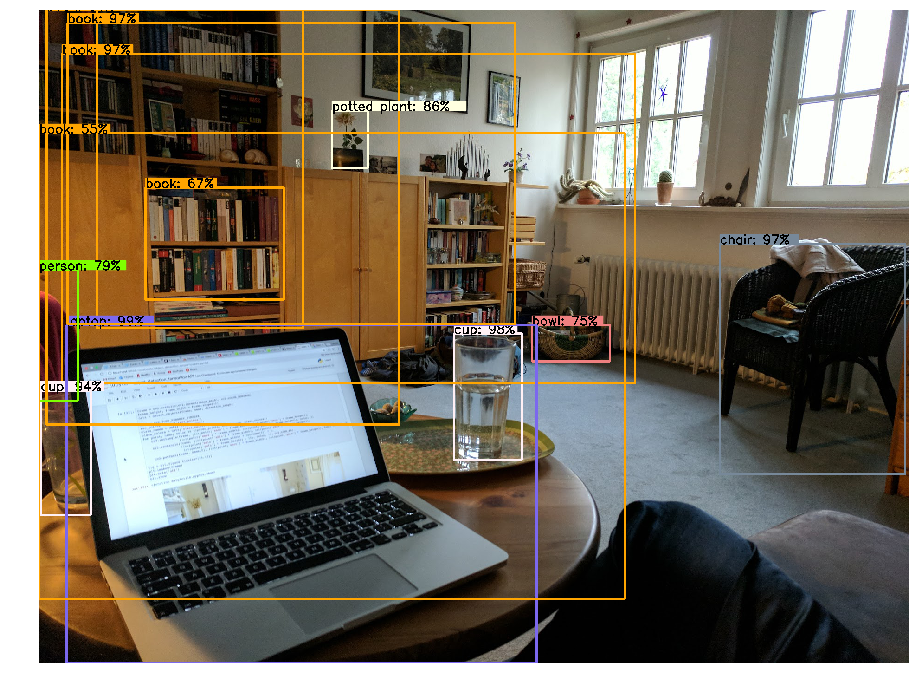

In [83]:
image_folder = 'images/'
image_name = '1.jpg'
url = 'https://lh3.googleusercontent.com/OfxZ0McIzYXJfafRnFavXs7R5mm6tyHuIuaGaw6l8GUun03FKPjW288rytTtrMexBztWJeVFmTR8YccAW-SPBirbwDXucI_jPz70HURLSvBxQ6o8fVlZaZ4gCvR2zz-awOfATNJTdVjsvaHkrCcXAaIdEtlLaKMAH3MZRFGCACrMhHjyFvDyPF-GDEIIHXBP7NzjHR_KLO-5a7loGbzbRMYWf9kaS4h-6QX-h6l1QeNHqwD7jIOlYKsUBHc9umAxTFwzlMYe7yg4MZJMb0C8TpFszeCHUfnov0srVlD_dutHDkUcb2Mx_er5Al_OdRYRuFxVX-p7i1F1fkiWJyUTwjur2qQOvi2z7JdX7ESv6P-GnPVOeBgZ802QIk5VEg4raYBfMhkjWdzJfImaANQqvYyabEYzSiHXgHF3mdEWfn0C6N9l4RQI6oaGpspVVPJUD5WH0CnAN1-Q4zmb2a9QWK5X66LVWtGmhCjYem7jq5zKzQQezwvaIKlNH9iKyMK0DTT9xPZ15cCYh8_cJYDJfcOBl8Tz6F2N_22gTtycpkhvztk1s5D3N8oepou153SrnbEkXERN9dfCAMtrB2JBBTQwo4hQ3J6RWGmPbj7m820=w1876-h1406-no'
to_download = True

image_path = get_image_path(image_name, to_download, url)
detect_objects_on_image(image_path)

In [ ]:
# close the session graph
sess.close()

# Detecting objects on a webcam stream

In [ ]:
queue_size = 4
num_workers = cpu_count()
width = 480
height = 360

input_q = Queue(maxsize=queue_size)
output_q = Queue(maxsize=queue_size)
pool = Pool(num_workers, worker, (input_q, output_q))
    
video_cap = WebcamVideoStream(src=0,width=width,height=height).start()
status = False

print('[INFO] Initialising object detection on webcam using {} workers.'.format(num_workers))

while True:
    frame = video_cap.read()
    input_q.put(frame)
        
    if output_q.empty():
#         if status:
#             for point, name, color in zip(rec_points, class_names, class_colors):
#                 cv2.rectangle(frame, (int(point['xmin'] * width), int(point['ymin'] * height)),
#                               (int(point['xmax'] * width), int(point['ymax'] * height)), color, 3)
#                 cv2.rectangle(frame, (int(point['xmin'] * width), int(point['ymin'] * height)),
#                               (int(point['xmin'] * width) + len(name[0]) * 6,
#                                int(point['ymin'] * height) - 10), color, -1, cv2.LINE_AA)
#                 cv2.putText(frame, name[0], (int(point['xmin'] * width), int(point['ymin'] * height)), font,
#                             0.3, (0, 0, 0), 1)
#             cv2.imshow('Video', frame)
        pass  # fill up queue
    else:
        if not status:    
            print('[INFO] Webcam detection started!')
            status = True
            
        font = cv2.FONT_HERSHEY_SIMPLEX
        data = output_q.get()
        rec_points = data['rect_points']
        class_names = data['class_names']
        class_colors = data['class_colors']
        for point, name, color in zip(rec_points, class_names, class_colors):
            cv2.rectangle(frame, (int(point['xmin'] * width), int(point['ymin'] * height)),
                          (int(point['xmax'] * width), int(point['ymax'] * height)), color, 3)
            cv2.rectangle(frame, (int(point['xmin'] * width), int(point['ymin'] * height)),
                          (int(point['xmin'] * width) + len(name[0]) * 6,
                           int(point['ymin'] * height) - 10), color, -1, cv2.LINE_AA)
            cv2.putText(frame, name[0], (int(point['xmin'] * width), int(point['ymin'] * height)), font,
                        0.3, (0, 0, 0), 1)
        cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

pool.terminate()
video_cap.stop()
cv2.destroyAllWindows()
print('[INFO] Detection stopped!')